# Outliers

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

import importlib
importlib.reload(mpl); importlib.reload(plt); importlib.reload(sns)

sns.reset_orig()
sns.set(font_scale=1.5)
%matplotlib inline

---

# Gaussian Outliers

In [2]:
%reload_ext sql
%sql postgresql://localhost:5432/postgres

Connecting to 'postgresql://localhost:5432/postgres'

In [3]:
%sql SELECT setseed(0.42) -- to fix randomness

Running query in 'postgresql://localhost:5432/postgres'

1 rows affected.

setseed
""


Just like a Python package, we need to import `tablefunc` in order to use the `normal_rand` function.

In [4]:
%sql CREATE EXTENSION IF NOT EXISTS tablefunc;

Running query in 'postgresql://localhost:5432/postgres'

++
||
++
++

Assume our datapoints are truly Normal. Simulate them in `observations`.
* 1000 datapoints, $\mu = 50, \sigma = 5$.

Let's also plot them as a histogram.

In [5]:
%sql DROP TABLE IF EXISTS observations CASCADE;
%sql CREATE TABLE observations AS \
     SELECT normal_rand AS x \
     FROM normal_rand(1000, 50, 5);

results = %sql SELECT x FROM observations;

Running query in 'postgresql://localhost:5432/postgres'

Running query in 'postgresql://localhost:5432/postgres'

1000 rows affected.

Running query in 'postgresql://localhost:5432/postgres'

1000 rows affected.

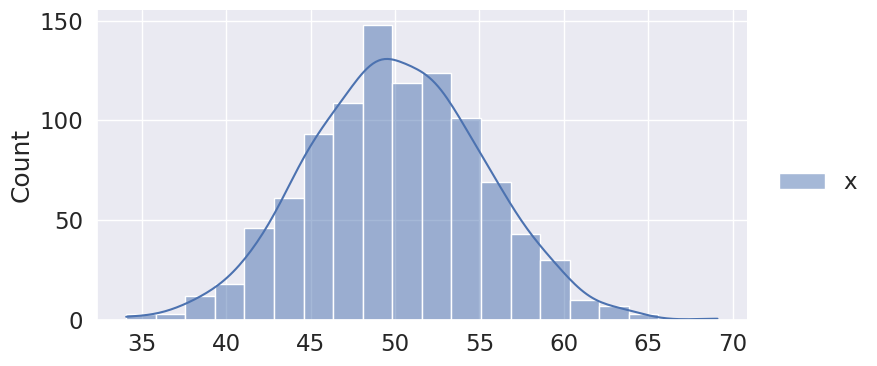

In [6]:
sns.displot(results.dict(), fill=True, kde=True, bins=20,
            height=4, aspect=2)

Construct a view called `normal_outliers` using the **2 sigma** metric.

In [7]:
%%sql
CREATE OR REPLACE VIEW normal_outliers AS
WITH bounds AS (
   SELECT avg(x) - 2*stddev(x) AS lo,
   avg(x) + 2*stddev(x) AS hi
   FROM observations
)
SELECT x AS outlier
FROM observations o, bounds b 
WHERE x NOT BETWEEN b.lo AND b.hi;

Running query in 'postgresql://localhost:5432/postgres'

++
||
++
++

In [8]:
# query the view
%sql SELECT * FROM normal_outliers;

Running query in 'postgresql://localhost:5432/postgres'

43 rows affected.

outlier
62.51902228435532
36.771098281539025
38.96317561111138
62.406289277098914
64.10352780551739
38.52887252302025
38.100961703076415
39.199185726693685
37.13632846401815
39.01589352253799


## What does this code do?

Running query in 'postgresql://localhost:5432/postgres'

1957 rows affected.

(30.0, 70.0)

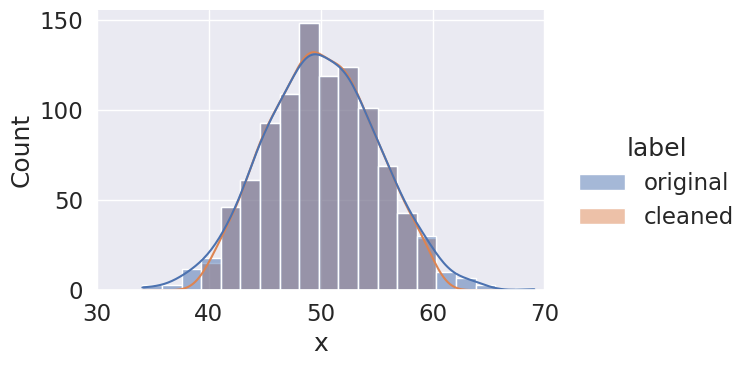

In [9]:
results = %sql SELECT x, 'original' AS label \
               FROM observations \
               UNION ALL \
               SELECT x, 'cleaned' AS label\
               FROM observations \
               WHERE x NOT IN \
                   (SELECT * FROM normal_outliers)
sns.displot(results.dict(), x="x", kind='hist',
            hue='label', kde=True, bins=20,
            height=4, aspect=1.5)
plt.xlim(30, 70)

## What if we suddenly had extremes?

Make the max 10x of its size.

In [10]:
%sql UPDATE observations SET x = x*10 \
      WHERE x = (SELECT MAX(x) FROM observations);

Running query in 'postgresql://localhost:5432/postgres'

1 rows affected.

++
||
++
++

In [11]:
%sql SELECT min(x), max(x) FROM observations

Running query in 'postgresql://localhost:5432/postgres'

1 rows affected.

min,max
34.08383473064803,690.9600503881296


Running query in 'postgresql://localhost:5432/postgres'

1999 rows affected.

(30.0, 700.0)

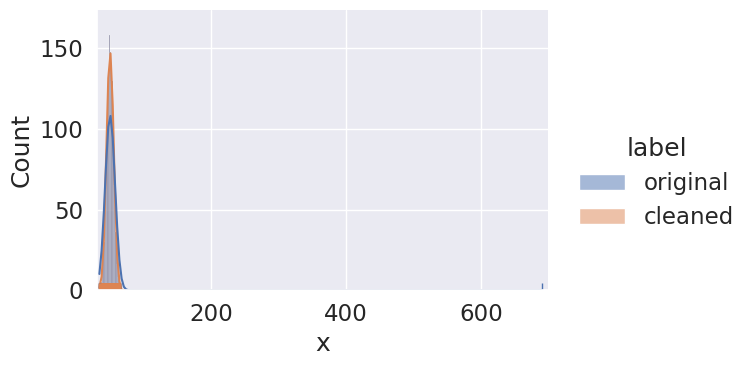

In [12]:
results = %sql SELECT x, 'original' AS label \
               FROM observations \
               UNION ALL \
               SELECT x, 'cleaned' AS label\
               FROM observations \
               WHERE x NOT IN \
                   (SELECT * FROM normal_outliers)
sns.displot(results.dict(), x="x", kind='hist',
            hue='label', kde=True, bins=np.linspace(32, 70, 20),
            height=4, aspect=1.5, rug=True)
plt.xlim(30, 700)

This is super zoomed out, let's just focus on the portion where most of the values lie.

Running query in 'postgresql://localhost:5432/postgres'

1999 rows affected.

(30.0, 70.0)

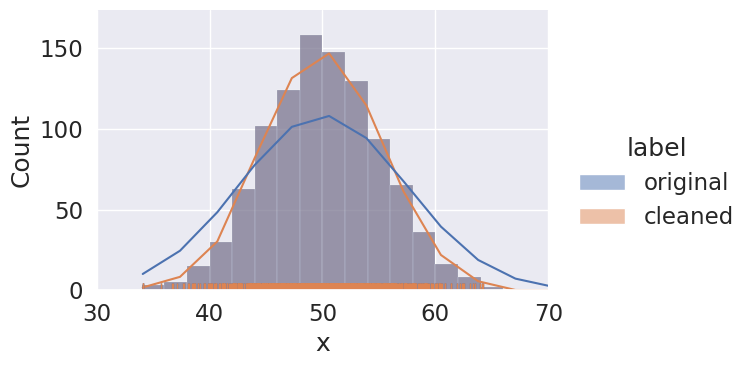

In [13]:
results = %sql SELECT x, 'original' AS label \
               FROM observations \
               UNION ALL \
               SELECT x, 'cleaned' AS label\
               FROM observations \
               WHERE x NOT IN \
                   (SELECT * FROM normal_outliers)
sns.displot(results.dict(), x="x", kind='hist',
            hue='label', kde=True, bins=np.linspace(32, 70, 20),
            height=4, aspect=1.5, rug=True)
plt.xlim(30, 70)

As you can see, the 10x outlier is masking the other outliers!

In [14]:
## reset before moving on
%sql UPDATE observations SET x = x/10 \
      WHERE x = (SELECT MAX(x) FROM OBSERVATIONS);

Running query in 'postgresql://localhost:5432/postgres'

1 rows affected.

++
||
++
++

# Winsorization

In [15]:
import numpy as np

In [16]:
arr = np.array([92, 19, 101, 58, 1053, 91, 26, 78, 10, 13, -40, 101, 86, 85, 15, 89, 89, 28, -5, 41])
arr

array([  92,   19,  101,   58, 1053,   91,   26,   78,   10,   13,  -40,
        101,   86,   85,   15,   89,   89,   28,   -5,   41])

OK, so we constructed an array. Let's look at the mean and median, and then try to compute the 5% winsorization cutoffs

In [17]:
np.mean(arr), np.median(arr)

(np.float64(101.5), np.float64(68.0))

In [18]:
np.percentile(arr, 95, method='nearest')

np.int64(101)

In [19]:
np.percentile(arr, 5, method='nearest')

np.int64(-5)

Now here's the winsorized version (we've manually done the replacement, exercise for you to try to replace it using a program)

In [20]:
arr_winsorized = np.array([92, 19, 101, 58, 101, 91, 26, 78, 10, 13, -5, 101, 86, 85, 15, 89, 89, 28, -5, 41])
arr_winsorized

array([ 92,  19, 101,  58, 101,  91,  26,  78,  10,  13,  -5, 101,  86,
        85,  15,  89,  89,  28,  -5,  41])

In [21]:
np.mean(arr_winsorized), np.median(arr_winsorized)

(np.float64(55.65), np.float64(68.0))

As you can see, the mean has gotten closer to the median now!

# Trimming vs. Winsorization

## Trimming in SQL

Let's look at the trimming approach. We will use a 1% trimming on either side.

In [22]:
%%sql
CREATE OR REPLACE VIEW p1p99 AS
SELECT percentile_cont(.01) WITHIN GROUP (ORDER BY x) AS p1,
           percentile_cont(.99) WITHIN GROUP (ORDER BY x) AS p99
      FROM observations;
SELECT * FROM p1p99;

Running query in 'postgresql://localhost:5432/postgres'

1 rows affected.

p1,p99
38.473525551352004,62.18869201373432


In [23]:
%%sql
CREATE OR REPLACE VIEW trimmed_observations AS
SELECT o.x, 'trimmed' AS label
  FROM observations o, p1p99 p
 WHERE o.x BETWEEN p.p1 AND p.p99
UNION ALL
SELECT o.x, 'original' AS label
  FROM observations o;

CREATE OR REPLACE VIEW trimmed_outliers AS
SELECT o.*
  FROM observations o, p1p99 p
 WHERE o.x NOT BETWEEN p.p1 AND p.p99;

Running query in 'postgresql://localhost:5432/postgres'

++
||
++
++

Running query in 'postgresql://localhost:5432/postgres'

1980 rows affected.

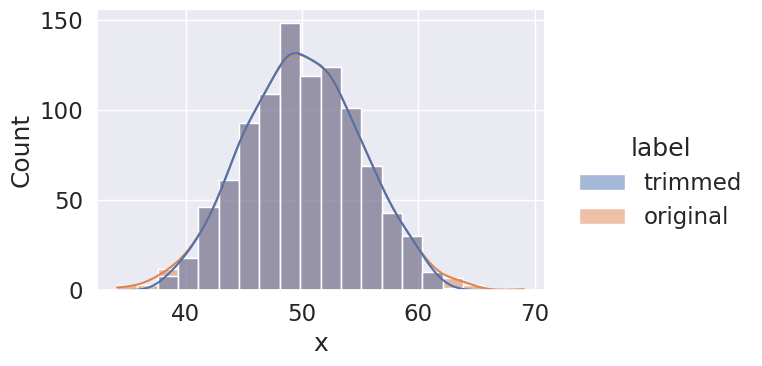

In [24]:
results = %sql SELECT * from trimmed_observations
sns.displot(results.dict(), x="x", kind='hist', hue='label', kde=True, bins=20,
           height=4, aspect=1.5)

## Does corruption affect Trimming?
We'll start by corrupting one value as before

In [26]:
# corrupt one value
%sql UPDATE observations SET x = x*10 \
      WHERE x = (SELECT MAX(x) FROM observations);

Running query in 'postgresql://localhost:5432/postgres'

1 rows affected.

++
||
++
++

Because we are trimming based on the order of the data and not on the distribution statistics (mean/SD), 
the results are unchanged from before. You can confirm this by recomputing `trimmed_observations` above, but we will just reuse it.

Running query in 'postgresql://localhost:5432/postgres'

1980 rows affected.

(30.0, 70.0)

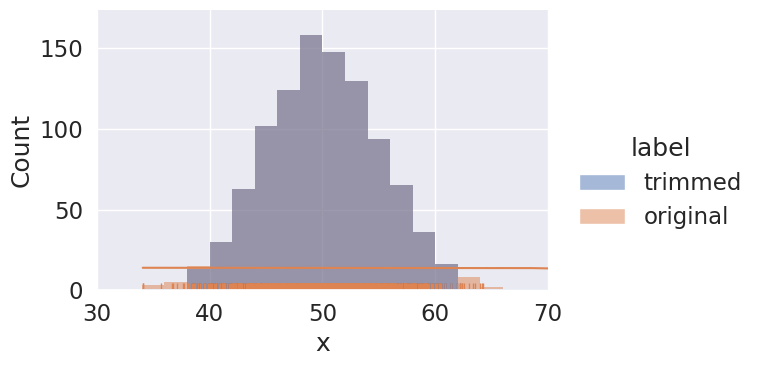

In [28]:
results = %sql SELECT * from trimmed_observations
sns.displot(results.dict(), x="x", kind='hist',
            hue='label', kde=True, bins=np.linspace(32, 70, 20),
            height=4, aspect=1.5, rug=True)
plt.xlim(30, 70)

## Winsorization in SQL

In [29]:
# reset before moving on
%sql UPDATE observations SET x = x*10 \
       WHERE x = (SELECT MAX(x) FROM OBSERVATIONS);

Running query in 'postgresql://localhost:5432/postgres'

1 rows affected.

++
||
++
++

In [30]:
%%sql
CREATE OR REPLACE VIEW winsorized_observations AS
SELECT CASE WHEN o.x BETWEEN p.p1 AND p.p99 THEN o.x
            WHEN o.x < p.p1 THEN p.p1
            WHEN o.x > p.p99 THEN p.p99
        END AS x,
      'winsorized' AS label
  FROM observations o, p1p99 p
UNION ALL
SELECT o.x, 'original' AS label
  FROM observations o;

Running query in 'postgresql://localhost:5432/postgres'

++
||
++
++

Running query in 'postgresql://localhost:5432/postgres'

2000 rows affected.

(30.0, 70.0)

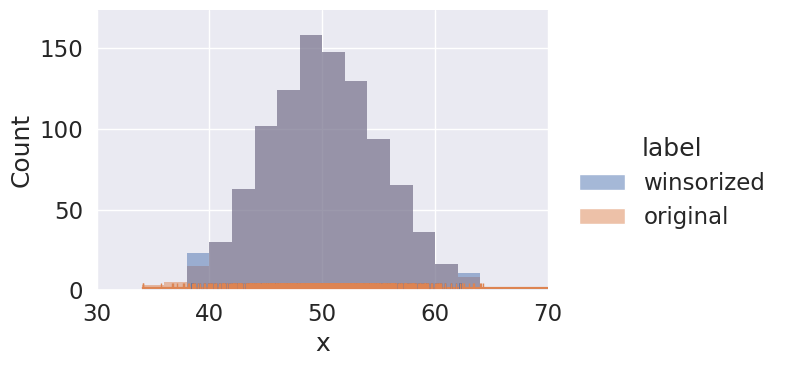

In [31]:
results = %sql SELECT * from winsorized_observations
sns.displot(results.dict(), x="x", kind='hist',
            hue='label', kde=True, bins=np.linspace(32, 70, 20),
            height=4, aspect=1.5, rug=True)
plt.xlim(30, 70)

Now, to compare all three:

In [32]:
%%sql 
SELECT 'orig' AS distribution, min(x),
       percentile_disc(.25) WITHIN GROUP (ORDER BY x) as p25,
       percentile_disc(.50) WITHIN GROUP (ORDER BY x) as median,
       percentile_disc(.75) WITHIN GROUP (ORDER BY x) as p75,
       max(x), avg(x), stddev(x), count(x) 
       FROM observations
UNION ALL
SELECT 'winsorized', min(x),
       percentile_disc(.25) WITHIN GROUP (ORDER BY x) as p25,
       percentile_disc(.50) WITHIN GROUP (ORDER BY x) as median,
       percentile_disc(.75) WITHIN GROUP (ORDER BY x) as p75,
       max(x), avg(x), stddev(x), count(x) 
       FROM winsorized_observations WHERE label = 'winsorized'
UNION ALL 
SELECT 'trimmed', min(x),
       percentile_disc(.25) WITHIN GROUP (ORDER BY x) as p25,
       percentile_disc(.50) WITHIN GROUP (ORDER BY x) as median,
       percentile_disc(.75) WITHIN GROUP (ORDER BY x) as p75,
       max(x), avg(x), stddev(x), count(x) 
       FROM trimmed_observations WHERE label = 'trimmed';

Running query in 'postgresql://localhost:5432/postgres'

3 rows affected.

distribution,min,p25,median,p75,max,avg,stddev,count
orig,34.08383473064803,46.47800115252697,49.987248988480594,53.47651370034104,69096.00503881296,119.07739168892617,2183.4313368223343,1000
winsorized,38.473525551352004,46.47800115252697,49.987248988480594,53.47651370034104,62.18869201373432,50.05234593514045,5.033921886057612,1000
trimmed,38.476749957707256,46.546205889364096,49.987248988480594,53.40902074473377,62.18689511626117,50.04665689743836,4.794169689804586,980


# Hampel X84

We'll now go through computing median (center), MAD (dispersion) and then the Hampel X84 approach

In [33]:
%%sql
-- percentile_disc returns an actual data value near the percentile
-- percentile_cont returns an interpolated value at the percentile
CREATE OR REPLACE VIEW median AS
(SELECT percentile_disc(0.5) WITHIN GROUP (ORDER BY x) as median
  FROM observations);

Running query in 'postgresql://localhost:5432/postgres'

++
||
++
++

In [34]:
%%sql
CREATE OR REPLACE VIEW mad AS
WITH
absdevs AS
(SELECT abs(x - median) as d
   FROM observations, median)
SELECT percentile_disc(0.5) WITHIN GROUP (ORDER BY d) as mad
  FROM absdevs;
    
SELECT median, mad
  FROM median, mad;

Running query in 'postgresql://localhost:5432/postgres'

1 rows affected.

median,mad
49.987248988480594,3.4949009132056545


In [35]:
%%sql
CREATE OR REPLACE VIEW hampelx84x2_observations AS
SELECT o.x,
      'hampelx84x2' AS label
  FROM observations o, median, mad
 WHERE o.x BETWEEN (median-2*1.4826*mad) AND (median+2*1.4826*mad)
UNION ALL
SELECT o.x, 'orig' AS label
  FROM observations o;

CREATE OR REPLACE VIEW Hampel84x2_outliers AS
SELECT x
  FROM observations o, median, mad
 WHERE x NOT BETWEEN (median - 2*1.4826*mad) AND (median + 2*1.4826*mad);

Running query in 'postgresql://localhost:5432/postgres'

++
||
++
++

Running query in 'postgresql://localhost:5432/postgres'

1959 rows affected.

(30.0, 70.0)

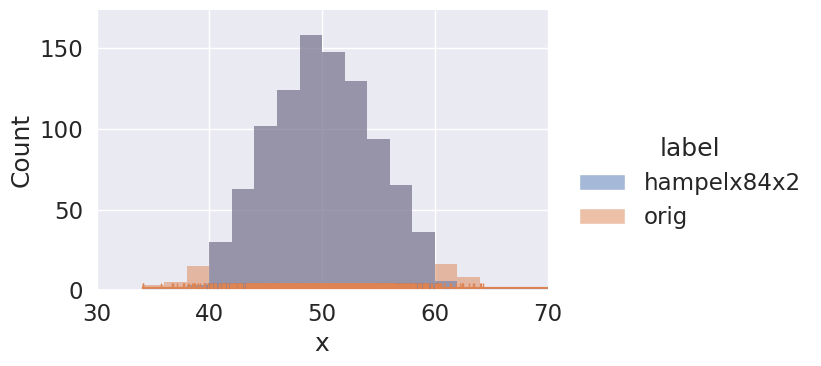

In [36]:
results = %sql SELECT * FROM hampelx84x2_observations
sns.displot(results.dict(), x="x", kind='hist',
            hue='label', kde=True, bins=np.linspace(32, 70, 20),
            height=4, aspect=1.5, rug=True)
plt.xlim(30, 70)